## Bin Packaging Problem(BPP)

### In the below code, we have implemented a Genetic Algorithm to solve bin packaging problem involving n items, each weighing a different amount, that must be placed in one of b bins in such a way as to make the total weight in each bin as nearly equal as possible.

### We will solve 2 versions of the same problem - BPP1, BPP2. While in BPP1, we have 10 bins, in BPP2 we have 100 bins. We will also try to experiment using several sizes of population along with various combinations of parameters in combination with crossover and/or mutation and explore the results.


In [1]:
import numpy as np
from random import choices
from random import randint
from random import random
import random
import typing
from typing import List
from typing import Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
import pdb
import matplotlib

Chromosome = typing.List[int]
Population = typing.List[Chromosome]

In [2]:
class Chromosome(list):
    """
   This class is used to hold chromosome/solution information
   Attributes
   ----------
    total_bins : int
        total no of bins used
    no_of_items : int
        the total no of items given
    bpp : int
        Bin Packaging Problem Version - either 1 or 2 
    """
    def __init__(self, total_bins, no_of_items, bpp: int):
        """
         Parameters
        ----------
        solution  : List
            Chromosome containing a random solution to the BPP
        fitness : int
            Contains the fitness value of the chromosome
        """
        self.total_bins  = total_bins
        self.no_of_items = no_of_items
        self.bpp         = bpp
        self.solution    = np.array(choices(np.arange(1,total_bins+1), k = no_of_items))
        self.fitness     = evaluate_fitness(self.solution, self.total_bins, self.bpp)
    
    def __iter__(self):
        '''Default Magic method Used to iterate through the Chromosome '''
        return (x for x in self.solution)
    
    def __str__(self):
        '''Used to print the Chromosome '''
        return str(self.solution)

In [3]:
class Population(list):  
    """
    This class is used to hold chromosome/solution information        
    """
    def __init__(self, total_bins, total_items, population_size, bpp):
        """
        Parameters
        ----------
        total_bins  : int
            total no of bins used
        total_items : int
            the total no of items given
        population_size : int
            total no. of solutions
        bpp : int
            Bin Packaging Problem Version - either 1 or 2 
        population : List[Chromosome]
            list of chromosomes
        population_fitness : int
            fitness value of solution
        population_size : int
            total no. of solutions
        """
        self.total_bins         = total_bins
        self.total_items        = total_items
        self.population_size    = population_size
        self.bpp                = bpp
        self.population         = []
        self.population_fitness = []
        self.generate_population(population_size = self.population_size,
                                total_bins = self.total_bins, 
                                total_items = self.total_items, 
                                bpp = self.bpp)
        

    def generate_population(self, population_size: int, total_bins: int, total_items: int, bpp: int) -> Population:
        """Generates a population of size 'population_size' """
        for _ in range(population_size):
            chromosome = Chromosome(total_bins, total_items, bpp)
            self.population.append(np.array(chromosome.solution))
            self.population_fitness.append(chromosome.fitness)
    
    def __iter__(self):
        return (x for x in self.population)
    
    def __str__(self):
        return str(self.population)

In [4]:
def binary_tournament(pop: Population) -> Population:
    """
    Parameters
    ----------
    Population
        selects two parents at random from the Population and returns them
    """
    return np.array(choices(population = list(pop.population),k=2))

def single_point_crossover(parent_1 : Chromosome, parent_2 : Chromosome) -> Tuple[Chromosome, Chromosome]:
    """
    Parameters
    ----------
    Population
        Chooses a random crossover point and performs single point crossover
    
    Returns
    -------
    Tuple : Tuple consisting of 2 crossed-over children 
    """
    assert len(list(parent_1)) == len(list(parent_2)), 'Parents should be of same length'
    crossover_point = randint(1, len(parent_1)) -1
    child_1 = np.hstack((parent_1[0:crossover_point], parent_2[crossover_point:]))
    child_2 = np.hstack((parent_2[0:crossover_point], parent_1[crossover_point:]))
    return child_1, child_2

def mutation(chromosome : Chromosome, k: int, no_of_bins) -> Chromosome:
    """
    Chooses a random Locus point and performs Mutation k times
    
    Returns
    -------
    Chromosome : Returns the mutated child 
    """    
    chromosome = list(chromosome.copy())
    locus = 0
    for i in np.arange(0,k):
        locus = randint(1, len(chromosome)) - 1
        chromosome[locus] = randint(1, no_of_bins)
    return chromosome

In [5]:
def weakest_replacement(child: Chromosome, population: Population) -> Population:
    """
    Replaces single parent(with worst fitness) in Population whose fitness value is worse than the child. 
    Parameters
    ----------
    child
        Instance of Chromosome class
    population
        Instance of Population Class
    Returns
    -------
    Population : Object of Population class
    """
    existing_worst_fitness = max(population.population_fitness)
    current_weakest_positions = np.where(population.population_fitness == existing_worst_fitness)[0]
    target = choices(current_weakest_positions, k = 1)[0]
    fitness_of_child = evaluate_fitness(chromosome = child, total_bins = population.total_bins, bpp = population.bpp)
    if fitness_of_child < existing_worst_fitness:
        population.population[target] = child
        population.population_fitness[target] = fitness_of_child
    elif fitness_of_child == existing_worst_fitness:
        population.population_fitness[target] = fitness_of_child
    return population
        
def evaluate_fitness(chromosome, total_bins, bpp: int) -> float:
    """
    Returns the fitness value of a chromosome. 
    
    Parameters
    ----------
    chromosome
        Instance of Chromosome class
    total_bins : int
        total no of bins
    bpp : int
        BPP type - 0 or 1
    
    Returns
    -------
    float : fitness value
    """
    bin_weights = defaultdict(lambda: 0) # creating a default dictionary with all the weights initialized to 0
    unique_bins = np.unique(chromosome) # gets all the unique bins from the solution
    if bpp == 1: #BPP 1
        for bin_number in unique_bins:
            indices = np.where(chromosome == bin_number)[0] + 1
            bin_weights[bin_number] = sum(indices)/2
    elif bpp == 2: #BPP 2
        for bin_number in unique_bins:
            indices = np.where(chromosome == bin_number)[0] + 1
            bin_weights[bin_number] = sum(indices**2)/2
    values = bin_weights.values()
    if len(unique_bins)!= total_bins: # When true, it indicates an empty bin. Hence, returning maximum weight as fitness
        return max(values)
    return max(values) - min(values)

In [6]:
seed_numbers = [11111, 22222, 33333, 44444, 231456]

In [7]:
def evolutionary_algorithm(total_bins, total_items, population_size, bpp,  Mk, co, termination_criterion):
    """
    Returns the minimum fitness values of all generations.  
 
    Parameters
    ----------
    total_bins : int
        total no. of bins
    total_items : int
        total no. of items given
    population_size : int
        size of the population
    bpp : int
        BPP type - 0 or 1
    Mk: int
        Mutation Rate i.e., the no. of genes to mutate
    co: int - 0 or 1
        When 0, crossover is skipped
        When 1, crossover is included
    termination_criterion: int
        no. of generations to generate/evolve
    Returns
    -------
    int : fitness value        
    """
    fitness_of_trails = []
    termination_criterion = range(termination_criterion)
    for seed_number in seed_numbers:
        np.random.seed(seed_number)
        random.seed(a=seed_number, version=2)
        generations_min_fitness = []
        current_pop = Population(total_bins = total_bins, total_items = total_items, 
                                 population_size = population_size, bpp = bpp)
        for i in termination_criterion:
            p1, p2 = binary_tournament(pop = current_pop)
            c1, c2 = p1,p2
            if co!=0:
                c1, c2 = single_point_crossover(p1, p2)
            if Mk!=0:
                c1 = mutation(c1, k = Mk, no_of_bins = current_pop.total_bins)
                c2 = mutation(c2, k = Mk, no_of_bins = current_pop.total_bins)
            current_pop = weakest_replacement(c1, population = current_pop)    
            current_pop = weakest_replacement(c2, population = current_pop)
            generations_min_fitness.append(min(current_pop.population_fitness))
        fitness_of_trails.append(generations_min_fitness)
    return fitness_of_trails

In [8]:
# BPP 1
all_gen_fitness_bpp1_exp1 = evolutionary_algorithm(total_bins = 10,  total_items = 500, population_size = 10,  bpp = 1, Mk = 1, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp1_exp2 = evolutionary_algorithm(total_bins = 10,  total_items = 500, population_size = 100, bpp = 1, Mk = 1, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp1_exp3 = evolutionary_algorithm(total_bins = 10,  total_items = 500, population_size = 10,  bpp = 1, Mk = 5, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp1_exp4 = evolutionary_algorithm(total_bins = 10,  total_items = 500, population_size = 100, bpp = 1, Mk = 5, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp1_exp5 = evolutionary_algorithm(total_bins = 10,  total_items = 500, population_size = 10,  bpp = 1, Mk = 5, co = 0, termination_criterion = 10000)
all_gen_fitness_bpp1_exp6 = evolutionary_algorithm(total_bins = 10,  total_items = 500, population_size = 10,  bpp = 1, Mk = 0, co = 1, termination_criterion = 10000)

# BPP 2
all_gen_fitness_bpp2_exp1 = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10,  bpp = 2, Mk = 1, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp2_exp2 = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 1, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp2_exp3 = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10,  bpp = 2, Mk = 5, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp2_exp4 = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 5, co = 1, termination_criterion = 10000)
all_gen_fitness_bpp2_exp5 = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10,  bpp = 2, Mk = 5, co = 0, termination_criterion = 10000)
all_gen_fitness_bpp2_exp6 = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10,  bpp = 2, Mk = 0, co = 1, termination_criterion = 10000)

In [9]:
fitness_of_all_experiments = [all_gen_fitness_bpp1_exp1, all_gen_fitness_bpp1_exp2, all_gen_fitness_bpp1_exp3, all_gen_fitness_bpp1_exp4, 
                              all_gen_fitness_bpp1_exp5, all_gen_fitness_bpp1_exp6, all_gen_fitness_bpp2_exp1, all_gen_fitness_bpp2_exp2, 
                              all_gen_fitness_bpp2_exp3, all_gen_fitness_bpp2_exp4, all_gen_fitness_bpp2_exp5, all_gen_fitness_bpp2_exp6]
termination_criterion = 10000

In [10]:
def plot_all_fitnesses(fitness_of_all):
    '''
    Plots experiment-wise fitness values recorded over 5 trails. Outputs one graph per experiment - 12 graphs in total 
    considering bpp-1 and bpp-2.
    
    Parameters:
    -----------
    fitness_of_all : List of all fitness values from all the six experiments from bpp 1 and bpp 2.
    '''
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
    title_font = {'fontname':'sans-serif', 'size':'10', 'fontweight': '649'}
    axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'645'}
    tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'645'}
    label_strs = [  "BPP - 1 \n    Pop_Size:'10', Mutation_Rate-'1', Cross_Over: 'Yes' ",
                    "BPP - 1 \n    Pop_Size:'100', Mutation_Rate-'1', Cross_Over: 'Yes' ",
                    "BPP - 1 \n    Pop_Size:'10', Mutation_Rate-'5', Cross_Over: 'Yes' ",
                    "BPP - 1 \n    Pop_Size:'100', Mutation_Rate-'5', Cross_Over: 'Yes' ",
                    "BPP - 1 \n    Pop_Size:'10', Mutation_Rate-'5', Cross_Over: 'NO' ",
                    "BPP - 1 \n    Pop_Size:'10', Mutation_Rate-'0', Cross_Over: 'Yes' ",
                    "BPP - 2 \n    Pop_Size:'10', Mutation_Rate-'1', Cross_Over: 'Yes' ",
                    "BPP - 2 \n    Pop_Size:'100', Mutation_Rate-'1', Cross_Over: 'Yes' ",
                    "BPP - 2 \n    Pop_Size:'10', Mutation_Rate-'5', Cross_Over: 'Yes' ",
                    "BPP - 2 \n    Pop_Size:'100', Mutation_Rate-'5', Cross_Over: 'Yes' ",
                    "BPP - 2 \n    Pop_Size:'10', Mutation_Rate-'5', Cross_Over: 'NO' ",
                    "BPP - 2 \n    Pop_Size:'10', Mutation_Rate-'0', Cross_Over: 'Yes' "]
    x = range(termination_criterion)
    legend_properties = {'weight':'bold'}
    for index, exp in enumerate(fitness_of_all):
        plt.style.use('tableau-colorblind10')
        plt.figure(figsize=(5, 3.6), dpi = 85)
        plt.xticks(**tick_font)
        plt.yticks(**tick_font)
        plt.title(label_strs[index],**title_font)
        plt.plot(x, exp[0], label = 'Trail 1')
        plt.plot(x, exp[1], label = 'Trail 2')
        plt.plot(x, exp[2], label = 'Trail 3')
        plt.plot(x, exp[3], label = 'Trail 4')
        plt.plot(x, exp[4], label = 'Trail 5')
        plt.xlabel('Generations', **axis_font)
        plt.ylabel('Fitness', **axis_font)
        plt.legend(loc='best', fontsize = 10.5, prop=legend_properties)
        plt.show()

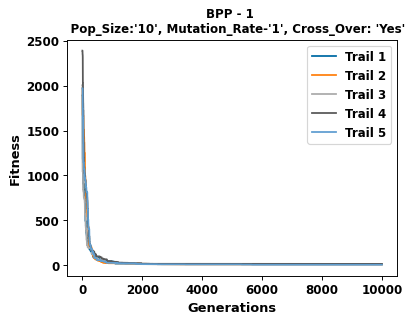

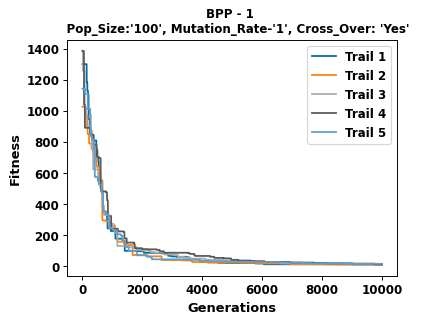

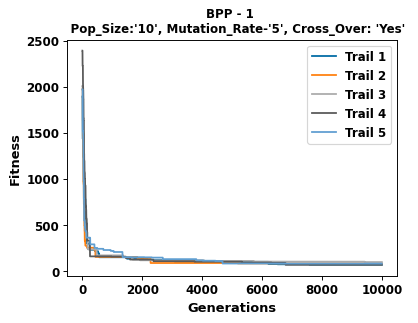

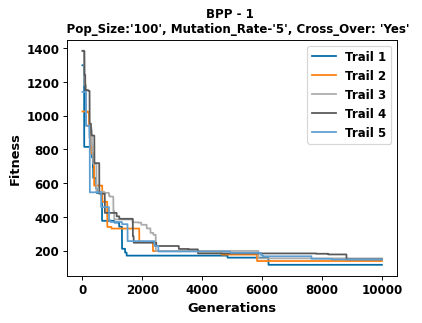

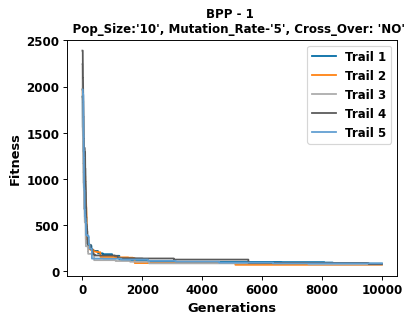

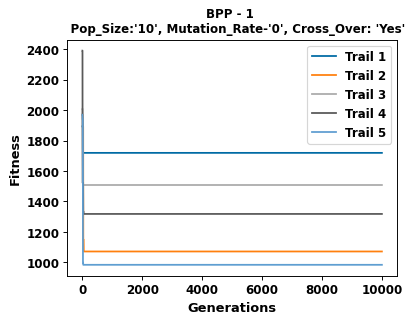

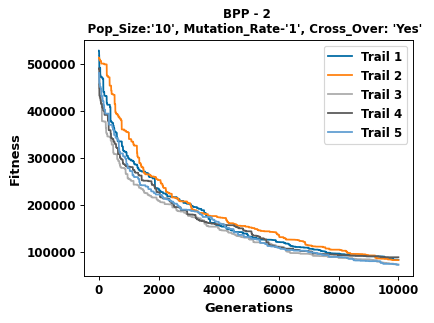

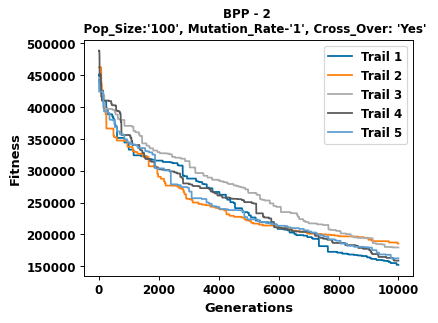

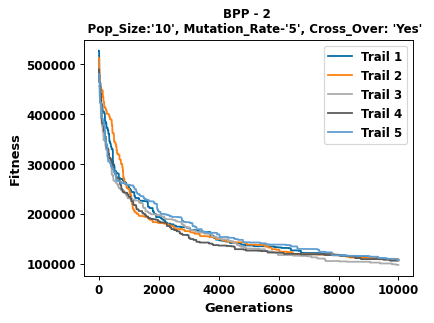

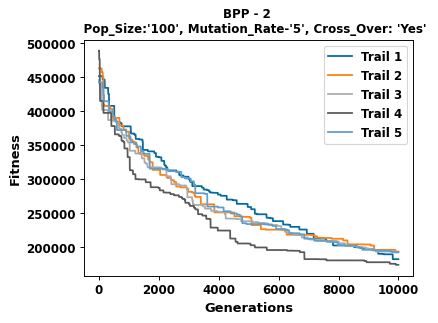

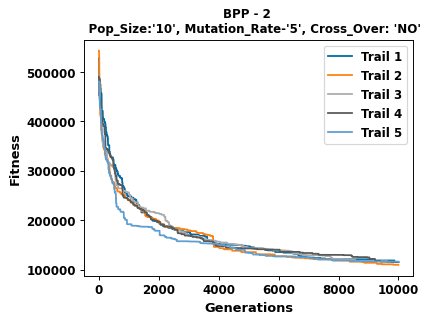

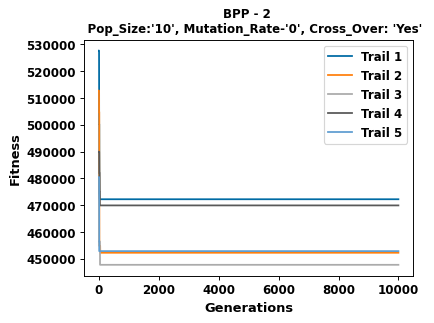

In [11]:
plot_all_fitnesses(fitness_of_all_experiments)

## Fitness Averages

The above 12 graphs depict 12 experiments with various combinations of parameters on bpp-1 and bpp-2. Let us try to summarise all the above graphs into 2 graphs where graph represents a problem and each line in the graph indicates the average fitness value of each experiment.

In [12]:
# Calculating average fitness values of every generation in 5 trails recorded over 6 experiments for 2 problems
avg_all_gen_fitness_bpp1_exp1 = []
avg_all_gen_fitness_bpp1_exp2 = []
avg_all_gen_fitness_bpp1_exp3 = []
avg_all_gen_fitness_bpp1_exp4 = []
avg_all_gen_fitness_bpp1_exp5 = []
avg_all_gen_fitness_bpp1_exp6 = []
avg_all_gen_fitness_bpp2_exp1 = []
avg_all_gen_fitness_bpp2_exp2 = []
avg_all_gen_fitness_bpp2_exp3 = []
avg_all_gen_fitness_bpp2_exp4 = []
avg_all_gen_fitness_bpp2_exp5 = []
avg_all_gen_fitness_bpp2_exp6 = []

for i in range(10000):
    avg_all_gen_fitness_bpp1_exp1.append((all_gen_fitness_bpp1_exp1[0][i] + all_gen_fitness_bpp1_exp1[1][i] + all_gen_fitness_bpp1_exp1[2][i] + all_gen_fitness_bpp1_exp1[3][i] + all_gen_fitness_bpp1_exp1[4][i])/5)
    avg_all_gen_fitness_bpp1_exp2.append((all_gen_fitness_bpp1_exp2[0][i] + all_gen_fitness_bpp1_exp2[1][i] + all_gen_fitness_bpp1_exp2[2][i] + all_gen_fitness_bpp1_exp2[3][i] + all_gen_fitness_bpp1_exp2[4][i])/5)
    avg_all_gen_fitness_bpp1_exp3.append((all_gen_fitness_bpp1_exp3[0][i] + all_gen_fitness_bpp1_exp3[1][i] + all_gen_fitness_bpp1_exp3[2][i] + all_gen_fitness_bpp1_exp3[3][i] + all_gen_fitness_bpp1_exp3[4][i])/5)
    avg_all_gen_fitness_bpp1_exp4.append((all_gen_fitness_bpp1_exp4[0][i] + all_gen_fitness_bpp1_exp4[1][i] + all_gen_fitness_bpp1_exp4[2][i] + all_gen_fitness_bpp1_exp4[3][i] + all_gen_fitness_bpp1_exp4[4][i])/5)
    avg_all_gen_fitness_bpp1_exp5.append((all_gen_fitness_bpp1_exp5[0][i] + all_gen_fitness_bpp1_exp5[1][i] + all_gen_fitness_bpp1_exp5[2][i] + all_gen_fitness_bpp1_exp5[3][i] + all_gen_fitness_bpp1_exp5[4][i])/5)
    avg_all_gen_fitness_bpp1_exp6.append((all_gen_fitn;lkjuyi-io9i888ess_bpp1_exp6[0][i] + all_gen_fitness_bpp1_exp6[1][i] + all_gen_fitness_bpp1_exp6[2][i] + all_gen_fitness_bpp1_exp6[3][i] + all_gen_fitness_bpp1_exp6[4][i])/5)
    avg_all_gen_fitness_bpp2_exp1.append((all_gen_fitness_bpp2_exp1[0][i] + all_gen_fitness_bpp2_exp1[1][i] + all_gen_fitness_bpp2_exp1[2][i] + all_gen_fitness_bpp2_exp1[3][i] + all_gen_fitness_bpp2_exp1[4][i])/5)
    avg_all_gen_fitness_bpp2_exp2.append((all_gen_fitness_bpp2_exp2[0][i] + all_gen_fitness_bpp2_exp2[1][i] + all_gen_fitness_bpp2_exp2[2][i] + all_gen_fitness_bpp2_exp2[3][i] + all_gen_fitness_bpp2_exp2[4][i])/5)
    avg_all_gen_fitness_bpp2_exp3.append((all_gen_fitness_bpp2_exp3[0][i] + all_gen_fitness_bpp2_exp3[1][i] + all_gen_fitness_bpp2_exp3[2][i] + all_gen_fitness_bpp2_exp3[3][i] + all_gen_fitness_bpp2_exp3[4][i])/5)
    avg_all_gen_fitness_bpp2_exp4.append((all_gen_fitness_bpp2_exp4[0][i] + all_gen_fitness_bpp2_exp4[1][i] + all_gen_fitness_bpp2_exp4[2][i] + all_gen_fitness_bpp2_exp4[3][i] + all_gen_fitness_bpp2_exp4[4][i])/5)
    avg_all_gen_fitness_bpp2_exp5.append((all_gen_fitness_bpp2_exp5[0][i] + all_gen_fitness_bpp2_exp5[1][i] + all_gen_fitness_bpp2_exp5[2][i] + all_gen_fitness_bpp2_exp5[3][i] + all_gen_fitness_bpp2_exp5[4][i])/5)
    avg_all_gen_fitness_bpp2_exp6.append((all_gen_fitness_bpp2_exp6[0][i] + all_gen_fitness_bpp2_exp6[1][i] + all_gen_fitness_bpp2_exp6[2][i] + all_gen_fitness_bpp2_exp6[3][i] + all_gen_fitness_bpp2_exp6[4][i])/5)
    
avg_fitness_list_bpp1 = [avg_all_gen_fitness_bpp1_exp1, avg_all_gen_fitness_bpp1_exp2, avg_all_gen_fitness_bpp1_exp3, 
                         avg_all_gen_fitness_bpp1_exp4, avg_all_gen_fitness_bpp1_exp5, avg_all_gen_fitness_bpp1_exp6] 
avg_fitness_list_bpp2 = [avg_all_gen_fitness_bpp2_exp1, avg_all_gen_fitness_bpp2_exp2, avg_all_gen_fitness_bpp2_exp3, 
                         avg_all_gen_fitness_bpp2_exp4, avg_all_gen_fitness_bpp2_exp5, avg_all_gen_fitness_bpp2_exp6]

### BPP 1 Avg Fitness

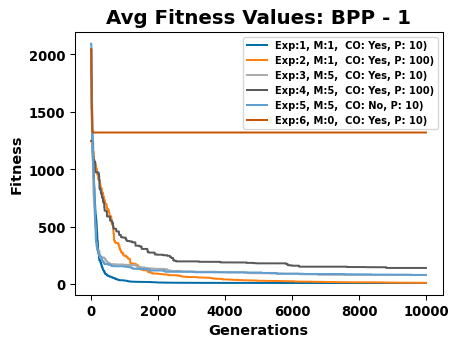

In [13]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'15', 'fontweight': '749'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'745'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'745'}
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(5, 3.6), dpi = 95)
termination_criterion = 10000
x = range(termination_criterion)
legend_properties = {'weight':'bold', 'size':'7.5'}
plt.plot(x, avg_fitness_list_bpp1[0], label = 'Exp:1, M:1,  CO: Yes, P: 10)')
plt.plot(x, avg_fitness_list_bpp1[1], label = 'Exp:2, M:1,  CO: Yes, P: 100)')
plt.plot(x, avg_fitness_list_bpp1[2], label = 'Exp:3, M:5,  CO: Yes, P: 10)')
plt.plot(x, avg_fitness_list_bpp1[3], label = 'Exp:4, M:5,  CO: Yes, P: 100)')
plt.plot(x, avg_fitness_list_bpp1[4], label = 'Exp:5, M:5,  CO: No, P: 10)')
plt.plot(x, avg_fitness_list_bpp1[5], label = 'Exp:6, M:0,  CO: Yes, P: 10)')
plt.xlabel('Generations', **axis_font)
plt.title('Avg Fitness Values: BPP - 1', **title_font)
plt.ylabel('Fitness', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.legend(loc='best',prop=legend_properties)
plt.show()

### BPP 2 Avg Fitness

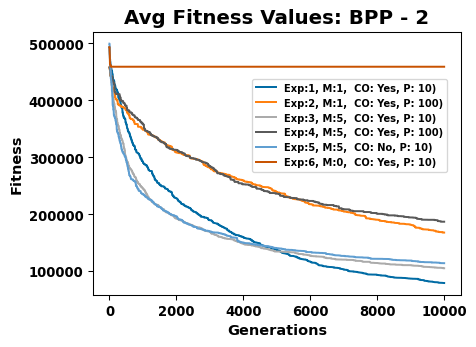

In [14]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'15', 'fontweight': '749'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'745'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'745'}
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(5, 3.6), dpi = 95)
termination_criterion = 10000
x = range(termination_criterion)
legend_properties = {'weight':'bold', 'size':'7.5'}
plt.plot(x, avg_fitness_list_bpp2[0], label = 'Exp:1, M:1,  CO: Yes, P: 10)')
plt.plot(x, avg_fitness_list_bpp2[1], label = 'Exp:2, M:1,  CO: Yes, P: 100)')
plt.plot(x, avg_fitness_list_bpp2[2], label = 'Exp:3, M:5,  CO: Yes, P: 10)')
plt.plot(x, avg_fitness_list_bpp2[3], label = 'Exp:4, M:5,  CO: Yes, P: 100)')
plt.plot(x, avg_fitness_list_bpp2[4], label = 'Exp:5, M:5,  CO: No, P: 10)')
plt.plot(x, avg_fitness_list_bpp2[5], label = 'Exp:6, M:0,  CO: Yes, P: 10)')
plt.xlabel('Generations', **axis_font)
plt.title('Avg Fitness Values: BPP - 2', **title_font)
plt.ylabel('Fitness', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.legend(loc='best',prop=legend_properties, bbox_to_anchor=(0.42,0.45))

plt.show()

# Further Experiments

### Population(10) VS Mutation (No Crossover)

In [15]:
fitness_p10_M1     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10,  bpp = 2, Mk = 1, co = 0, termination_criterion = 10000)
fitness_p10_M2     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10,  bpp = 2, Mk = 2, co = 0, termination_criterion = 10000)
fitness_p10_M5     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 5, co = 0, termination_criterion = 10000)
fitness_p10_M10    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 10, co = 0, termination_criterion = 10000)
fitness_p10_M20    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 20, co = 0, termination_criterion = 10000)
fitness_p10_M30    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 30, co = 0, termination_criterion = 10000)
fitness_p10_M50    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 50, co = 0, termination_criterion = 10000)
fitness_p10_M100   = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 100, co = 0, termination_criterion = 10000)

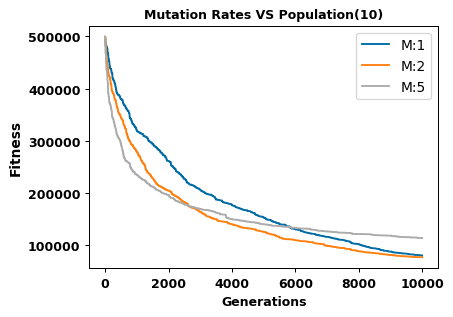

In [16]:
# AVERAGE Calculator
a = fitness_p10_M1
b = fitness_p10_M2
c = fitness_p10_M5
d = fitness_p10_M10
e = fitness_p10_M20
f = fitness_p10_M30
g = fitness_p10_M50
h = fitness_p10_M100


avg_fitness_p10_M1 = []
avg_fitness_p10_M2 = []
avg_fitness_p10_M5 = []
avg_fitness_p10_M10 = []
avg_fitness_p10_M20 = []
avg_fitness_p10_M30 = []
avg_fitness_p10_M50 = []
avg_fitness_p10_M100 = []

for i in range(10000):
    avg_fitness_p10_M1.append((a[0][i] + a[1][i] + a[2][i] + a[3][i] + a[4][i])/5)
    avg_fitness_p10_M2.append((b[0][i] + b[1][i] + b[2][i] + b[3][i] + b[4][i])/5)
    avg_fitness_p10_M5.append((c[0][i] + c[1][i] + c[2][i] + c[3][i] + c[4][i])/5)
    avg_fitness_p10_M10.append((d[0][i] + d[1][i] + d[2][i] + d[3][i] + d[4][i])/5)
    avg_fitness_p10_M20.append((e[0][i] + e[1][i] + e[2][i] + e[3][i] + e[4][i])/5)
    avg_fitness_p10_M30.append((f[0][i] + f[1][i] + f[2][i] + f[3][i] + f[4][i])/5)
    avg_fitness_p10_M50.append((g[0][i] + g[1][i] + g[2][i] + g[3][i] + g[4][i])/5)
    avg_fitness_p10_M100.append((h[0][i] + h[1][i] + h[2][i] + h[3][i] + h[4][i])/5)


matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'10', 'fontweight': '749'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'745'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'745'}
termination_criterion = 10000
plt.style.use('tableau-colorblind10')

plt.figure(figsize=(5,3.5), dpi = 90)
plt.xticks(fontsize = 10, fontweight ='551')
plt.yticks(fontsize = 10, fontweight ='551')
plt.xlabel('Generations', **title_font)
plt.ylabel('Fitness', **axis_font)
legend_properties = {'weight':'550'}


plt.title(label = 'Mutation Rates VS Population(10)', **title_font)
plt.plot(range(termination_criterion),    avg_fitness_p10_M1,   label = 'M:1')
plt.plot(range(termination_criterion),    avg_fitness_p10_M2,   label = 'M:2')
plt.plot(range(termination_criterion),    avg_fitness_p10_M5,   label = 'M:5')
plt.legend(loc='best', fontsize = 9, prop = legend_properties)
plt.legend(bbox_to_anchor = (1, 1), fontsize = 11)
plt.show()

### Population(100) VS Mutation (No Crossover)

In [17]:
fitness_p100_M1     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 1,  co = 0, termination_criterion = 10000)
fitness_p100_M2     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 2,  co = 0, termination_criterion = 10000)
fitness_p100_M5     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 5,  co = 0, termination_criterion = 10000)
fitness_p100_M10    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 10, co = 0, termination_criterion = 10000)
fitness_p100_M20    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 20, co = 0, termination_criterion = 10000)
fitness_p100_M30    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 30, co = 0, termination_criterion = 10000)
fitness_p100_M50    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 50, co = 0, termination_criterion = 10000)
fitness_p100_M100   = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 100,co = 0, termination_criterion = 10000)

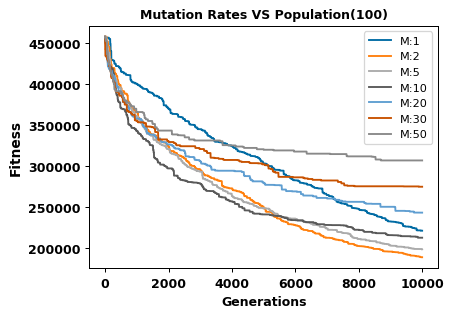

In [18]:
# AVERAGE Calculator
a = fitness_p100_M1
b = fitness_p100_M2
c = fitness_p100_M5
d = fitness_p100_M10
e = fitness_p100_M20
f = fitness_p100_M30
g = fitness_p100_M50
h = fitness_p100_M100


avg_fitness_p100_M1 = []
avg_fitness_p100_M2 = []
avg_fitness_p100_M5 = []
avg_fitness_p100_M10 = []
avg_fitness_p100_M20 = []
avg_fitness_p100_M30 = []
avg_fitness_p100_M50 = []
avg_fitness_p100_M100 = []

for i in range(10000):
    avg_fitness_p100_M1.append((a[0][i] + a[1][i] + a[2][i] + a[3][i] + a[4][i])/5)
    avg_fitness_p100_M2.append((b[0][i] + b[1][i] + b[2][i] + b[3][i] + b[4][i])/5)
    avg_fitness_p100_M5.append((c[0][i] + c[1][i] + c[2][i] + c[3][i] + c[4][i])/5)
    avg_fitness_p100_M10.append((d[0][i] + d[1][i] + d[2][i] + d[3][i] + d[4][i])/5)
    avg_fitness_p100_M20.append((e[0][i] + e[1][i] + e[2][i] + e[3][i] + e[4][i])/5)
    avg_fitness_p100_M30.append((f[0][i] + f[1][i] + f[2][i] + f[3][i] + f[4][i])/5)
    avg_fitness_p100_M50.append((g[0][i] + g[1][i] + g[2][i] + g[3][i] + g[4][i])/5)
    avg_fitness_p100_M100.append((h[0][i] + h[1][i] + h[2][i] + h[3][i] + h[4][i])/5)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'10', 'fontweight': '749'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'745'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'745'}
termination_criterion = 10000
plt.style.use('tableau-colorblind10')
# plt.style.use('seaborn-colorblind')

plt.figure(figsize=(5,3.5), dpi = 90)
plt.xticks(fontsize = 10, fontweight ='551')
plt.yticks(fontsize = 10, fontweight ='551')
plt.xlabel('Generations', **title_font)
plt.ylabel('Fitness', **axis_font)
legend_properties = {'weight':'550'}

plt.plot(range(termination_criterion),    avg_fitness_p100_M1,   label = 'M:1')
plt.plot(range(termination_criterion),    avg_fitness_p100_M2,   label = 'M:2')
plt.plot(range(termination_criterion),    avg_fitness_p100_M5,   label = 'M:5')
plt.plot(range(termination_criterion),    avg_fitness_p100_M10,  label = 'M:10')
plt.plot(range(termination_criterion),    avg_fitness_p100_M20,  label = 'M:20')
plt.plot(range(termination_criterion),    avg_fitness_p100_M30,  label = 'M:30')
plt.plot(range(termination_criterion),    avg_fitness_p100_M50,  label = 'M:50')
plt.legend(loc='best', fontsize = 9)
plt.title(label = 'Mutation Rates VS Population(100)', **title_font)
plt.show()

### Population(1000) VS Mutation (No Crossover)

In [19]:
fitness_p1000_M1     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000,  bpp = 2, Mk = 1, co = 0, termination_criterion = 10000)
fitness_p1000_M2     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000,  bpp = 2, Mk = 2, co = 0, termination_criterion = 10000)
fitness_p1000_M5     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 5, co = 0, termination_criterion = 10000)
fitness_p1000_M10    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 10, co = 0, termination_criterion = 10000)
fitness_p1000_M20    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 20, co = 0, termination_criterion = 10000)
fitness_p1000_M30    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 30, co = 0, termination_criterion = 10000)
fitness_p1000_M50    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 50, co = 0, termination_criterion = 10000)
fitness_p1000_M100   = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 100, co = 0, termination_criterion = 10000)

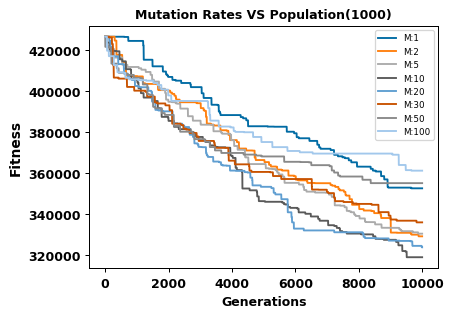

In [20]:
# AVERAGE Calculator
a = fitness_p1000_M1
b = fitness_p1000_M2
c = fitness_p1000_M5
d = fitness_p1000_M10
e = fitness_p1000_M20
f = fitness_p1000_M30
g = fitness_p1000_M50
h = fitness_p1000_M100

avg_fitness_p1000_M1 = []
avg_fitness_p1000_M2 = []
avg_fitness_p1000_M5 = []
avg_fitness_p1000_M10 = []
avg_fitness_p1000_M20 = []
avg_fitness_p1000_M30 = []
avg_fitness_p1000_M50 = []
avg_fitness_p1000_M100 = []
for i in range(10000):
    avg_fitness_p1000_M1.append((a[0][i] + a[1][i] + a[2][i] + a[3][i] + a[4][i])/5)
    avg_fitness_p1000_M2.append((b[0][i] + b[1][i] + b[2][i] + b[3][i] + b[4][i])/5)
    avg_fitness_p1000_M5.append((c[0][i] + c[1][i] + c[2][i] + c[3][i] + c[4][i])/5)
    avg_fitness_p1000_M10.append((d[0][i] + d[1][i] + d[2][i] + d[3][i] + d[4][i])/5)
    avg_fitness_p1000_M20.append((e[0][i] + e[1][i] + e[2][i] + e[3][i] + e[4][i])/5)
    avg_fitness_p1000_M30.append((f[0][i] + f[1][i] + f[2][i] + f[3][i] + f[4][i])/5)
    avg_fitness_p1000_M50.append((g[0][i] + g[1][i] + g[2][i] + g[3][i] + g[4][i])/5)
    avg_fitness_p1000_M100.append((h[0][i] + h[1][i] + h[2][i] + h[3][i] + h[4][i])/5)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'10', 'fontweight': '749'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'745'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'745'}
termination_criterion = 10000
plt.style.use('tableau-colorblind10')

plt.figure(figsize=(5,3.5), dpi = 90)
plt.xticks(fontsize = 10, fontweight ='551')
plt.yticks(fontsize = 10, fontweight ='551')
plt.xlabel('Generations', **title_font)
plt.ylabel('Fitness', **axis_font)
legend_properties = {'weight':'550'}


plt.title(label = 'Mutation Rates VS Population(1000)', **title_font)
plt.plot(range(termination_criterion),    avg_fitness_p1000_M1,   label = 'M:1')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M2,   label = 'M:2')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M5,   label = 'M:5')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M10,  label = 'M:10')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M20,  label = 'M:20')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M30,  label = 'M:30')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M50,  label = 'M:50')
plt.plot(range(termination_criterion),    avg_fitness_p1000_M100, label = 'M:100')
plt.legend(bbox_to_anchor = (1, 1), fontsize = 7)
plt.show()

### Population VS Crossover (No Mutation) - BPP 1

In [22]:
### Population VS Crossover (No Mutation)

fitness_p10_tc10k     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 1, Mk = 0, co = 1, termination_criterion = 10000)
fitness_p100_tc10k    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 1, Mk = 0, co = 1, termination_criterion = 10000)
fitness_p1000_tc10k   = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 1, Mk = 0, co = 1, termination_criterion = 10000)
fitness_p10000_tc10k  = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10000, bpp = 1, Mk = 0, co = 1, termination_criterion = 10000)

In [23]:
# AVERAGE Calculator
a = fitness_p10_tc10k
b = fitness_p100_tc10k
c = fitness_p1000_tc10k
d = fitness_p10000_tc10k
# e = fitness_p100000_tc10k

avg_fitness_p10_tc10k = []
avg_fitness_p100_tc10k = []
avg_fitness_p1000_tc10k = []
avg_fitness_p10000_tc10k = []
# avg_fitness_p100000_tc10k = [] 

for i in range(10000):
    avg_fitness_p10_tc10k.append((a[0][i] + a[1][i] + a[2][i] + a[3][i] + a[4][i])/5)
    avg_fitness_p100_tc10k.append((b[0][i] + b[1][i] + b[2][i] + b[3][i] + b[4][i])/5)
    avg_fitness_p1000_tc10k.append((c[0][i] + c[1][i] + c[2][i] + c[3][i] + c[4][i])/5)
    avg_fitness_p10000_tc10k.append((d[0][i] + d[1][i] + d[2][i] + d[3][i] + d[4][i])/5)
#     avg_fitness_p100000_tc10k.append((e[0][i] + e[1][i] + e[2][i] + e[3][i] + e[4][i])/5)

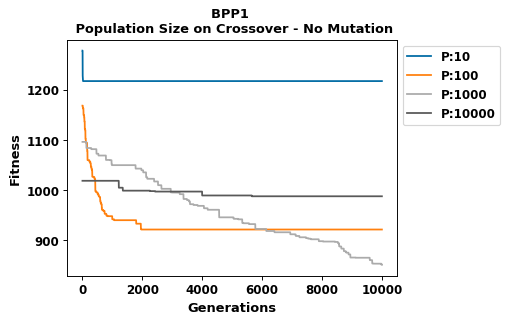

In [69]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'11', 'fontweight': '649'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'645'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'645'}
termination_criterion = 10000
x = range(termination_criterion)
# plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
# plt.figure(figsize=(5,4), dpi = 90)
plt.figure(figsize=(5,3.6), dpi = 85)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlabel('Generations', **title_font)
plt.ylabel('Fitness', **axis_font)
legend_properties = {'weight':'bold'}

plt.plot(x,    avg_fitness_p10_tc10k,  label = 'P:10')
plt.plot(x,    avg_fitness_p100_tc10k,  label = 'P:100')
plt.plot(x,    avg_fitness_p1000_tc10k,  label = 'P:1000')
plt.plot(x,    avg_fitness_p10000_tc10k,  label = 'P:10000')
# plt.plot(x,    avg_fitness_p10000_tc10k,  label = 'Pop_size:100000')
plt.legend(bbox_to_anchor=(1,1), prop=legend_properties)
# plt.legend(loc='best', fontsize = 10.5)
plt.title(label = 'BPP1 \n Population Size on Crossover - No Mutation', **title_font)
plt.show()

### Population VS Crossover (No Mutation) - BPP 2

In [25]:
### Population VS Crossover (No Mutation)

fitness_p10_tc10k_2     = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10, bpp = 2, Mk = 0, co = 1, termination_criterion = 10000)
fitness_p100_tc10k_2    = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 100, bpp = 2, Mk = 0, co = 1, termination_criterion = 10000)
fitness_p1000_tc10k_2   = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 1000, bpp = 2, Mk = 0, co = 1, termination_criterion = 10000)
fitness_p10000_tc10k_2  = evolutionary_algorithm(total_bins = 100, total_items = 500, population_size = 10000, bpp = 2, Mk = 0, co = 1, termination_criterion = 10000)

In [30]:
# AVERAGE Calculator
a = fitness_p10_tc10k_2
b = fitness_p100_tc10k_2
c = fitness_p1000_tc10k_2
d = fitness_p10000_tc10k_2

avg_fitness_p10_tc10k_2 = []
avg_fitness_p100_tc10k_2 = []
avg_fitness_p1000_tc10k_2 = []
avg_fitness_p10000_tc10k_2 = []

for i in range(10000):
    avg_fitness_p10_tc10k_2.append((a[0][i] + a[1][i] + a[2][i] + a[3][i] + a[4][i])/5)
    avg_fitness_p100_tc10k_2.append((b[0][i] + b[1][i] + b[2][i] + b[3][i] + b[4][i])/5)
    avg_fitness_p1000_tc10k_2.append((c[0][i] + c[1][i] + c[2][i] + c[3][i] + c[4][i])/5)
    avg_fitness_p10000_tc10k_2.append((d[0][i] + d[1][i] + d[2][i] + d[3][i] + d[4][i])/5)

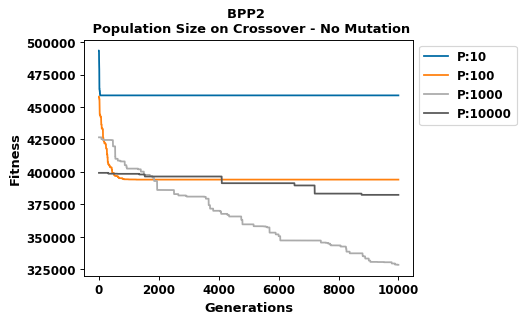

In [70]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'11', 'fontweight': '649'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'645'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'645'}
termination_criterion = 10000
x = range(termination_criterion)
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(5,3.6), dpi = 85)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlabel('Generations', **title_font)
plt.ylabel('Fitness', **axis_font)
legend_properties = {'weight':'bold'}

plt.plot(x,    avg_fitness_p10_tc10k_2,  label = 'P:10')
plt.plot(x,    avg_fitness_p100_tc10k_2,  label = 'P:100')
plt.plot(x,    avg_fitness_p1000_tc10k_2,  label = 'P:1000')
plt.plot(x,    avg_fitness_p10000_tc10k_2,  label = 'P:10000')
plt.legend(bbox_to_anchor=(1,1), prop=legend_properties)
plt.title(label = 'BPP2 \n Population Size on Crossover - No Mutation', **title_font)
plt.show()

## Mutation Modification using Local Search Heuristic

In [52]:
def local_improvement_mutation(chromosome : Chromosome, k: int, no_of_bins) -> Chromosome:
    child_fitness = evaluate_fitness(chromosome = chromosome, total_bins = no_of_bins, bpp = 1)
    locus = None
    new_fitness = child_fitness + 1 
    while(new_fitness > child_fitness):
        c = list(chromosome.copy())
        for i in np.arange(0,k):
            locus = randint(1, len(chromosome)) - 1
            c[locus] = randint(1, no_of_bins)
        new_fitness = evaluate_fitness(c,total_bins = no_of_bins, bpp = 1)
    return c

In [107]:
# Original Genetic Algorithm : BPP2  P:100, b:100, items:500, Mk:1 bpp:2
plt.style.use('ggplot')
fitness_of_trails = []
termination_criterion = range(10000)
for seed_number in [1000, 2000, 3000, 4000, 5000]:
    np.random.seed(seed_number)
    random.seed(a=seed_number, version=2)
    generations_min_fitness = []
    current_pop = Population(total_bins = 100, total_items = 500, population_size = 100, bpp = 2)
    for i in termination_criterion:
        p1, p2 = binary_tournament(pop = current_pop)
        c1, c2 = p1,p2
        c1, c2 = single_point_crossover(p1, p2)
        c1 = mutation(c1, k = 2, no_of_bins = current_pop.total_bins)
        c2 = mutation(c2, k = 2, no_of_bins = current_pop.total_bins)
        current_pop = weakest_replacement(c1, population = current_pop)    
        current_pop = weakest_replacement(c2, population = current_pop)
        generations_min_fitness.append(min(current_pop.population_fitness))
    fitness_of_trails.append(generations_min_fitness)
org_ga_fitness = fitness_of_trails

In [108]:
# Mutation Improvement P:100, b:100, items:500, Mk:2, bpp:2
plt.style.use('ggplot')
fitness_of_trails = []
termination_criterion = range(10000)
for seed_number in [1000, 2000, 3000, 4000, 5000]:
    np.random.seed(seed_number)
    random.seed(a=seed_number, version=2)
    generations_min_fitness = []
    current_pop = Population(total_bins = 100, total_items = 500, population_size = 100, bpp = 2)
    for i in termination_criterion:
        p1, p2 = binary_tournament(pop = current_pop)
        c1, c2 = p1,p2
        c1, c2 = single_point_crossover(p1, p2)
        # Using Local Improvement Mutation
        c1 = local_improvement_mutation(c1, k = 2, no_of_bins = current_pop.total_bins)
        c2 = local_improvement_mutation(c2, k = 2, no_of_bins = current_pop.total_bins)
        current_pop = weakest_replacement(c1, population = current_pop)    
        current_pop = weakest_replacement(c2, population = current_pop)
        generations_min_fitness.append(min(current_pop.population_fitness))
    fitness_of_trails.append(generations_min_fitness)
mutation_imp_fitness = fitness_of_trails

In [132]:
# Crossover Improvement P:100, b:100, items:500, Mk:2, bpp:2
plt.style.use('ggplot')
fitness_of_trails = []
termination_criterion = range(10000)
for seed_number in [1000, 2000, 3000, 4000, 5000]:
    np.random.seed(seed_number)
    random.seed(a=seed_number, version=2)
    generations_min_fitness = []
    current_pop = Population(total_bins = 100, total_items = 500, population_size = 100, bpp = 2)
    for i in termination_criterion:
        p1, p2 = binary_tournament(pop = current_pop)
        c1, c2 = single_point_crossover(p1, p2)
        c3, c4 = single_point_crossover(p1, p2)
        child_list = [c1, c2, c3, c4]
        child_list = random.sample(child_list, k = 4)
        c1 = mutation(child_list[0], k = 1, no_of_bins = current_pop.total_bins)
        c2 = mutation(child_list[1], k = 1, no_of_bins = current_pop.total_bins)
        c3 = child_list[2]
        c4 = child_list[3]
        current_pop = weakest_replacement(c1, population = current_pop)    
        current_pop = weakest_replacement(c2, population = current_pop)
        current_pop = weakest_replacement(c3, population = current_pop)
        current_pop = weakest_replacement(c4, population = current_pop)
        generations_min_fitness.append(min(current_pop.population_fitness))
    fitness_of_trails.append(generations_min_fitness)
crossoveer_imp_fitness = fitness_of_trails

In [111]:
# Mutation and Crossover Improvement P:100, b:100, items:500, Mk:2, bpp:2
plt.style.use('ggplot')
fitness_of_trails = []
termination_criterion = range(10000)
for seed_number in [1000, 2000, 3000, 4000, 5000]:
    np.random.seed(seed_number)
    random.seed(a=seed_number, version=2)
    generations_min_fitness = []
    current_pop = Population(total_bins = 100, total_items = 500, population_size = 100, bpp = 2)
    for i in termination_criterion:
        p1, p2 = binary_tournament(pop = current_pop)
        c1, c2 = p1,p2
        c3, c4 = p1,p2
        c1, c2 = single_point_crossover(p1, p2)
        c3, c4 = single_point_crossover(p1, p2)
        c1 = mutation(c1, k = 1, no_of_bins = current_pop.total_bins)
        c2 = mutation(c2, k = 1, no_of_bins = current_pop.total_bins)
        c3 = mutation(c2, k = 1, no_of_bins = current_pop.total_bins)
        c4 = mutation(c2, k = 1, no_of_bins = current_pop.total_bins)
        current_pop = weakest_replacement(c1, population = current_pop)    
        current_pop = weakest_replacement(c2, population = current_pop)
        current_pop = weakest_replacement(c3, population = current_pop)
        current_pop = weakest_replacement(c4, population = current_pop)
        generations_min_fitness.append(min(current_pop.population_fitness))
    fitness_of_trails.append(generations_min_fitness)
mutated_crossover_imp_fitness = fitness_of_trails

In [137]:
# Calculate the average fitnesses of the actual GA, Mutation modified, Crossover Modified and both Mutation 
# and Crossover Modified
avg_crossoveer_imp_fitness = []
avg_mutation_imp_fitness = []
avg_org_ga_fitness = []
avg_mutated_crossover_imp_fitness = []
for i in range(10000):
        avg_crossoveer_imp_fitness.append((crossoveer_imp_fitness[0][i] + crossoveer_imp_fitness[1][i] + crossoveer_imp_fitness[2][i] + crossoveer_imp_fitness[3][i] + crossoveer_imp_fitness[4][i])/5)
        avg_mutation_imp_fitness.append((mutation_imp_fitness[0][i] + mutation_imp_fitness[1][i] + mutation_imp_fitness[2][i] + mutation_imp_fitness[3][i] + mutation_imp_fitness[4][i])/5)
        avg_org_ga_fitness.append((org_ga_fitness[0][i] + org_ga_fitness[1][i] + org_ga_fitness[2][i] + org_ga_fitness[3][i] + org_ga_fitness[4][i])/5)
        avg_mutated_crossover_imp_fitness.append((mutated_crossover_imp_fitness[0][i] + mutated_crossover_imp_fitness[1][i] + mutated_crossover_imp_fitness[2][i] + mutated_crossover_imp_fitness[3][i] + mutated_crossover_imp_fitness[4][i])/5)

In [1]:
# Plot the average fitness values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)    
title_font = {'fontname':'sans-serif', 'size':'15', 'fontweight': '749'}
axis_font  = {'fontname':'sans-serif', 'size':'11', 'fontweight' :'745'}
tick_font  = {'fontname':'sans-serif', 'size':'10', 'fontweight' :'745'}
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(5, 3.6), dpi = 95)
termination_criterion = 10000
x = range(termination_criterion)
legend_properties = {'weight':'bold', 'size':'7.5'}
plt.plot(x, avg_org_ga_fitness, label = 'Original GA')
plt.plot(x, avg_mutation_imp_fitness,  label = 'Mutation Modification')
plt.plot(x, avg_crossoveer_imp_fitness,  label = 'Crossover Modification')
plt.plot(x, avg_mutated_crossover_imp_fitness,  label = 'Mutation - Crossover Modification')
plt.xlabel('Generations', **axis_font)
plt.title('Avg Fitness Values', **title_font)
plt.ylabel('Fitness', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.legend(loc='best',prop=legend_properties)#, bbox_to_anchor=(0.42,0.45))

plt.show()

NameError: name 'matplotlib' is not defined